<a href="https://colab.research.google.com/github/ayushtankha/TSP-Data-Science-Internship/blob/main/TSP_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
weather_df = pd.read_csv('/content/drive/MyDrive/Telecom/Tunisia Weather All Data.csv')


# MISSING VALUES

In [6]:
missing_values = (weather_df == -999.0).sum()

# Display columns with missing values
missing_values[missing_values > 0]


ALLSKY_SFC_SW_DWN       365
ALLSKY_KT               608
ALLSKY_SFC_LW_DWN       365
ALLSKY_SFC_PAR_TOT      608
CLRSKY_SFC_PAR_TOT     6818
ALLSKY_SFC_UV_INDEX    6831
ALLSKY_SFC_UVA         6818
ALLSKY_SFC_UVB         6818
dtype: int64

# EDA

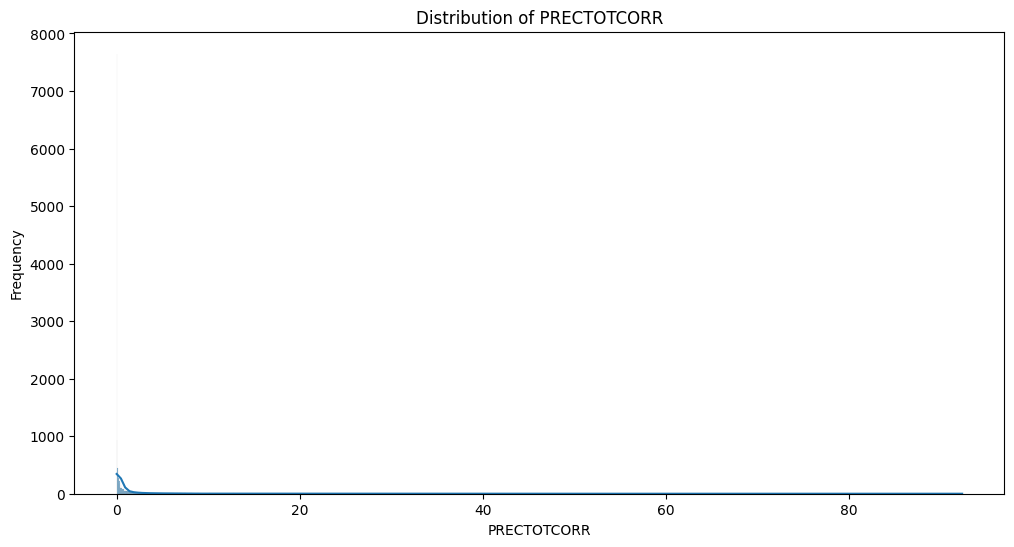

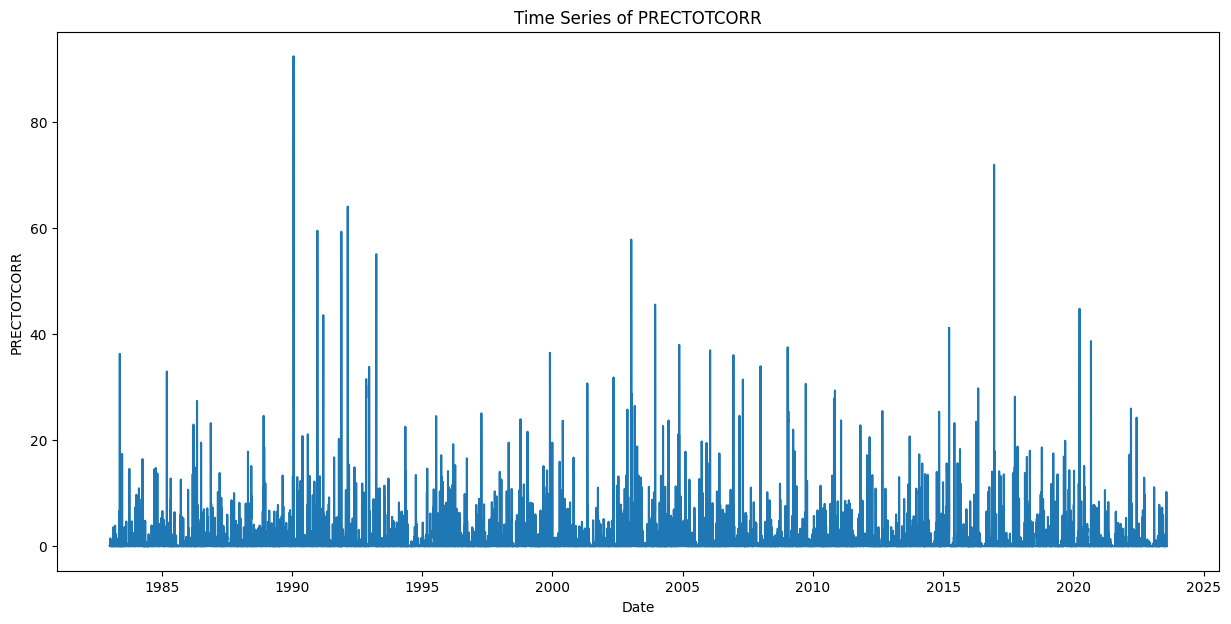

In [4]:
# Correctly create a date column for visualization purposes
weather_df['DATE'] = pd.to_datetime(weather_df['YEAR'].astype(str) + '-' + weather_df['MO'].astype(str) + '-' + weather_df['DY'].astype(str))

# Plotting the distribution of the 'PRECTOTCORR' feature
plt.figure(figsize=(12, 6))
sns.histplot(weather_df['PRECTOTCORR'], kde=True)
plt.title('Distribution of PRECTOTCORR')
plt.xlabel('PRECTOTCORR')
plt.ylabel('Frequency')
plt.show()

# Plotting a time series for 'PRECTOTCORR' over the years
plt.figure(figsize=(15, 7))
plt.plot(weather_df['DATE'], weather_df['PRECTOTCORR'])
plt.title('Time Series of PRECTOTCORR')
plt.xlabel('Date')
plt.ylabel('PRECTOTCORR')
plt.show()

# Distribution of PRECTOTCORR: The distribution is right-skewed, with a majority of the values clustered around the lower range. This suggests that many days had little to no rainfall, which is consistent with many weather datasets.

# DATA CLEANING

In [8]:
# Drop columns with a significant amount of missing data
columns_to_drop = ['ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB', 'CLRSKY_SFC_PAR_TOT']
weather_df_cleaned = weather_df.drop(columns=columns_to_drop)

# For columns with fewer missing values, use forward-fill to impute
weather_df_cleaned.replace(-999.0, np.nan, inplace=True)
weather_df_cleaned.fillna(method='ffill', inplace=True)

# Set 'DATE' as the index
weather_df_cleaned.set_index('DATE', inplace=True)

# Display the cleaned dataset
weather_df_cleaned.head()


,YEAR,MO,DY,ALLSKY_SFC_SW_DWN,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,T2M,T2MDEW,T2M_MAX,T2M_MIN,TS,WS10M,WD10M,WS50M,WD50M,PS,PRECTOTCORR,RH2M
DATE,,,,,,,,,,,,,,,,,,,
1983-01-01,1983,1,1,NaN,NaN,NaN,NaN,5.48,-0.01,13.02,-0.81,4.48,2.43,263.62,3.73,265.12,98.23,0.11,70.38
1983-01-02,1983,1,2,NaN,NaN,NaN,NaN,5.80,1.58,12.84,0.74,4.75,3.12,264.19,4.79,263.56,98.09,0.07,76.56
1983-01-03,1983,1,3,NaN,NaN,NaN,NaN,5.43,3.12,11.65,0.27,4.99,3.73,212.50,6.01,212.62,98.47,0.16,84.56
1983-01-04,1983,1,4,NaN,NaN,NaN,NaN,7.59,3.09,14.50,2.96,6.81,3.09,302.56,4.49,303.19,98.57,0.07,75.50
1983-01-05,1983,1,5,NaN,NaN,NaN,NaN,9.02,0.41,18.82,3.52,8.19,4.40,285.00,7.34,285.31,98.22,0.00,58.75


# DATA PREPROCESSING FOR LSTM

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [11]:
# Select and scale relevant features
features = weather_df[['PRECTOTCORR', 'RH2M', 'T2MDEW', 'WS10M']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert time series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

window_size = 3
data_supervised = series_to_supervised(scaled_features, n_in=window_size)
data_supervised_values = data_supervised.values

# Split data into training and test sets
train_size = int(len(data_supervised_values) * 0.8)
train, test = data_supervised_values[:train_size], data_supervised_values[train_size:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# List of regression models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor(n_estimators=100)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100)),
    ("Support Vector Regressor", SVR())
]

# Train and evaluate each model
results = {}
for name, model in models:
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    mae = mean_absolute_error(test_y, y_pred)
    rmse = mean_squared_error(test_y, y_pred, squared=False)
    r2 = r2_score(test_y, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

print(results)

{'Linear Regression': {'MAE': 0.07076510531377374, 'RMSE': 0.09292682361535606, 'R2': 0.2862603651965375}, 'Decision Tree': {'MAE': 0.09498854840746786, 'RMSE': 0.12457294071382406, 'R2': -0.28264083592792844}, 'Random Forest': {'MAE': 0.06938731493719277, 'RMSE': 0.09101610775903075, 'R2': 0.315309743355602}, 'Gradient Boosting': {'MAE': 0.06918945738204396, 'RMSE': 0.09082725554119896, 'R2': 0.31814816672620094}, 'Support Vector Regressor': {'MAE': 0.06973080476057995, 'RMSE': 0.09078689667821076, 'R2': 0.318753990398983}}


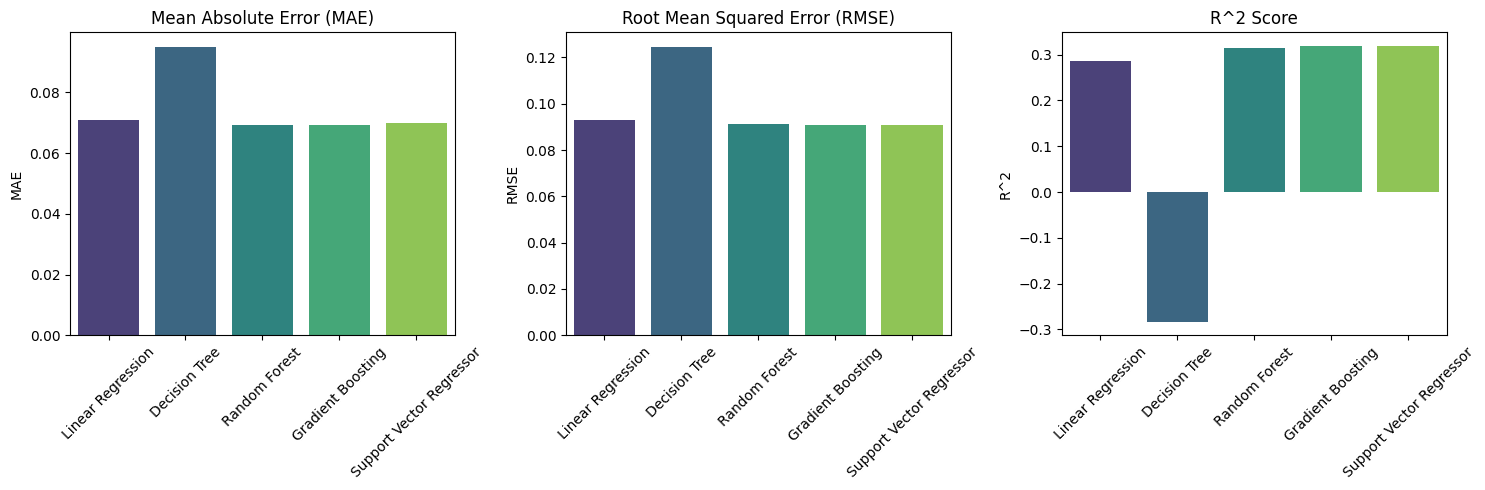

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract metric values for each model
mae_values = [results[model]["MAE"] for model in results]
rmse_values = [results[model]["RMSE"] for model in results]
r2_values = [results[model]["R2"] for model in results]

model_names = list(results.keys())

# Create bar plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=model_names, y=mae_values, palette="viridis")
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x=model_names, y=rmse_values, palette="viridis")
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x=model_names, y=r2_values, palette="viridis")
plt.title('R^2 Score')
plt.ylabel('R^2')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# MODEL EVALUATION WITH CV


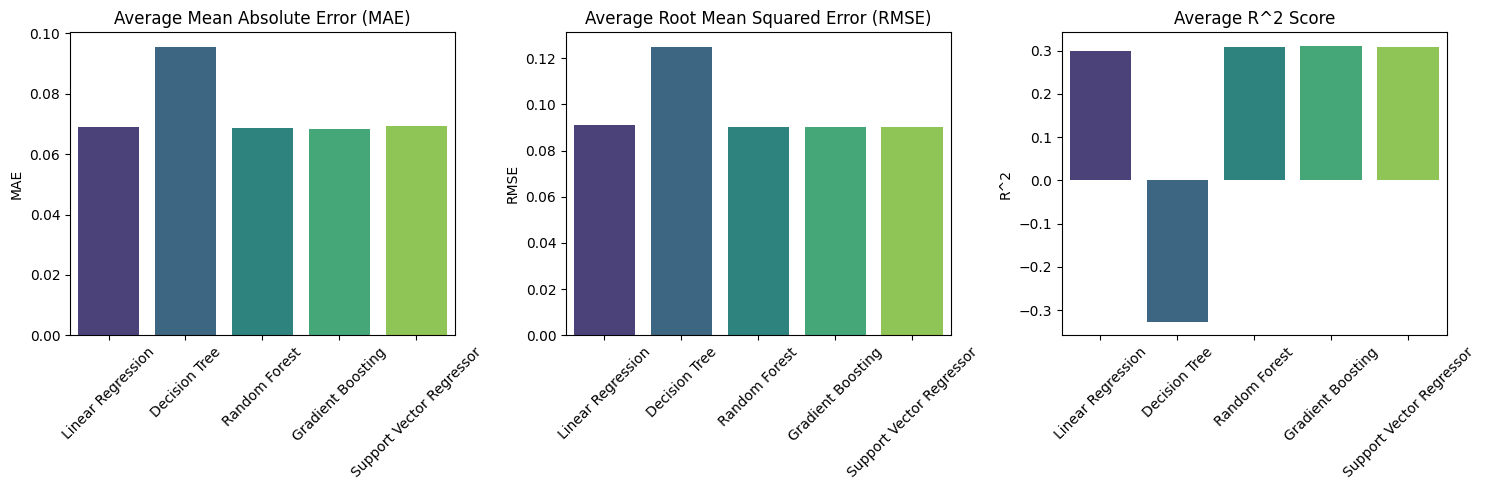

In [13]:
from sklearn.model_selection import TimeSeriesSplit

# Number of splits for Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store the results for each fold and model
all_results = {model: {"MAE": [], "RMSE": [], "R2": []} for model, _ in models}

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(data_supervised_values):
    CV_train, CV_test = data_supervised_values[train_index], data_supervised_values[test_index]
    CV_train_X, CV_train_y = CV_train[:, :-1], CV_train[:, -1]
    CV_test_X, CV_test_y = CV_test[:, :-1], CV_test[:, -1]

    # Training and evaluating each model for the current fold
    for name, model in models:
        # Train the model
        model.fit(CV_train_X, CV_train_y)
        # Predict on the test set
        y_pred = model.predict(CV_test_X)
        # Compute metrics
        mae = mean_absolute_error(CV_test_y, y_pred)
        rmse = mean_squared_error(CV_test_y, y_pred, squared=False)
        r2 = r2_score(CV_test_y, y_pred)
        # Store the results for the current fold
        all_results[name]["MAE"].append(mae)
        all_results[name]["RMSE"].append(rmse)
        all_results[name]["R2"].append(r2)

# Aggregate the results (average across all folds)
avg_results = {model: {"MAE": np.mean(all_results[model]["MAE"]),
                      "RMSE": np.mean(all_results[model]["RMSE"]),
                      "R2": np.mean(all_results[model]["R2"])} for model in all_results}

# Extract metric values for each model for visualization
avg_mae_values = [avg_results[model]["MAE"] for model in avg_results]
avg_rmse_values = [avg_results[model]["RMSE"] for model in avg_results]
avg_r2_values = [avg_results[model]["R2"] for model in avg_results]

# Create bar plots to compare average metric values across models
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=model_names, y=avg_mae_values, palette="viridis")
plt.title('Average Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x=model_names, y=avg_rmse_values, palette="viridis")
plt.title('Average Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x=model_names, y=avg_r2_values, palette="viridis")
plt.title('Average R^2 Score')
plt.ylabel('R^2')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# LSTM Data Preprocessing


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Data Loading and Preprocessing
weather_df = pd.read_csv('/content/drive/MyDrive/Telecom/Tunisia Weather All Data.csv')
weather_df['DATE'] = pd.to_datetime(weather_df['YEAR'].astype(str) + '-' + weather_df['MO'].astype(str) + '-' + weather_df['DY'].astype(str))
weather_df.set_index('DATE', inplace=True)
columns_to_drop = ['ALLSKY_SFC_UV_INDEX', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB', 'CLRSKY_SFC_PAR_TOT']
weather_df.drop(columns=columns_to_drop, inplace=True)
weather_df.replace(-999.0, np.nan, inplace=True)
weather_df.fillna(method='ffill', inplace=True)
features = weather_df[['PRECTOTCORR', 'RH2M', 'T2MDEW', 'WS10M']]

# 2. Feature Scaling and Conversion to Supervised Format
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)
def series_to_supervised_lstm(data, n_in=1, n_out=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg
window_size_lstm = 3
data_supervised_lstm = series_to_supervised_lstm(scaled_data, n_in=window_size_lstm)
n_obs = window_size_lstm * features.shape[1]
train_size_lstm = int(len(data_supervised_lstm) * 0.8)
train_lstm, test_lstm = data_supervised_lstm.values[:train_size_lstm], data_supervised_lstm.values[train_size_lstm:]
train_X_lstm, train_y_lstm = train_lstm[:, :n_obs], train_lstm[:, -features.shape[1]]
test_X_lstm, test_y_lstm = test_lstm[:, :n_obs], test_lstm[:, -features.shape[1]]
train_X_lstm = train_X_lstm.reshape((train_X_lstm.shape[0], window_size_lstm, features.shape[1]))
test_X_lstm = test_X_lstm.reshape((test_X_lstm.shape[0], window_size_lstm, features.shape[1]))

# 3. Building LSTM Model
def create_lstm_model(input_shape, neurons=50, dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 4. Cross-Validation with Hyperparameter Tuning
tscv = TimeSeriesSplit(n_splits=3)
best_score = float('inf')
best_params = {}
neurons_list = [30, 50]
dropout_list = [0.2, 0.3]
optimizer_list = ['adam', 'rmsprop']
for neurons in neurons_list:
    for dropout in dropout_list:
        for optimizer in optimizer_list:
            scores = []
            for train_index, val_index in tscv.split(train_X_lstm):
                X_train_fold, X_val_fold = train_X_lstm[train_index], train_X_lstm[val_index]
                y_train_fold, y_val_fold = train_y_lstm[train_index], train_y_lstm[val_index]
                model = create_lstm_model(input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
                                          neurons=neurons, dropout=dropout, optimizer=optimizer)
                es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                          epochs=50, callbacks=[es], verbose=1)
                mse = model.evaluate(X_val_fold, y_val_fold, verbose=1)
                scores.append(mse)
            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_params = {'neurons': neurons, 'dropout': dropout, 'optimizer': optimizer}

# 5. Model Training and Evaluation


print("Best Model Parameters:", best_params)


Epoch 1/50
93/93 [==============================] - 6s 15ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 2/50
93/93 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/50
93/93 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/50
93/93 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/50
93/93 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
93/93 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/50
93/93 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/50
93/93 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/50
93/93 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
93/93 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/50
93

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preprocessing (assuming data has been loaded into 'weather_df')
# ... (same as provided previously)

# 2. LSTM Model Training with Best Hyperparameters
best_lstm_model = Sequential()
best_lstm_model.add(LSTM(50, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2])))
best_lstm_model.add(Dropout(0.2))
best_lstm_model.add(Dense(1))
best_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_lstm_model.fit(train_X_lstm, train_y_lstm, epochs=100, callbacks=[es], verbose=0)

# 3. Making Predictions
lstm_predictions = best_lstm_model.predict(test_X_lstm).squeeze()
lstm_predictions = scaler.inverse_transform(np.concatenate([lstm_predictions.reshape(-1, 1), test_X_lstm[:, -1, 1:]], axis=1))[:, 0]

# 4. Evaluate the LSTM Model
mae_lstm = mean_absolute_error(test_y_lstm, lstm_predictions)
rmse_lstm = mean_squared_error(test_y_lstm, lstm_predictions, squared=False)
r2_lstm = r2_score(test_y_lstm, lstm_predictions)

# 5. Compare LSTM with Other Models
model_names = ["LSTM"]
avg_mae_values = [mae_lstm]  # Append LSTM results to your previous MAE results
avg_rmse_values = [rmse_lstm]  # Append LSTM results to your previous RMSE results
avg_r2_values = [r2_lstm]  # Append LSTM results to your previous R^2 results




93/93 [==============================] - 1s 2ms/step


In [25]:
print(avg_mae_values, avg_rmse_values,
avg_r2_values)

[0.6948380797955516] [1.2543632811387473] [-1467.9082325414463]


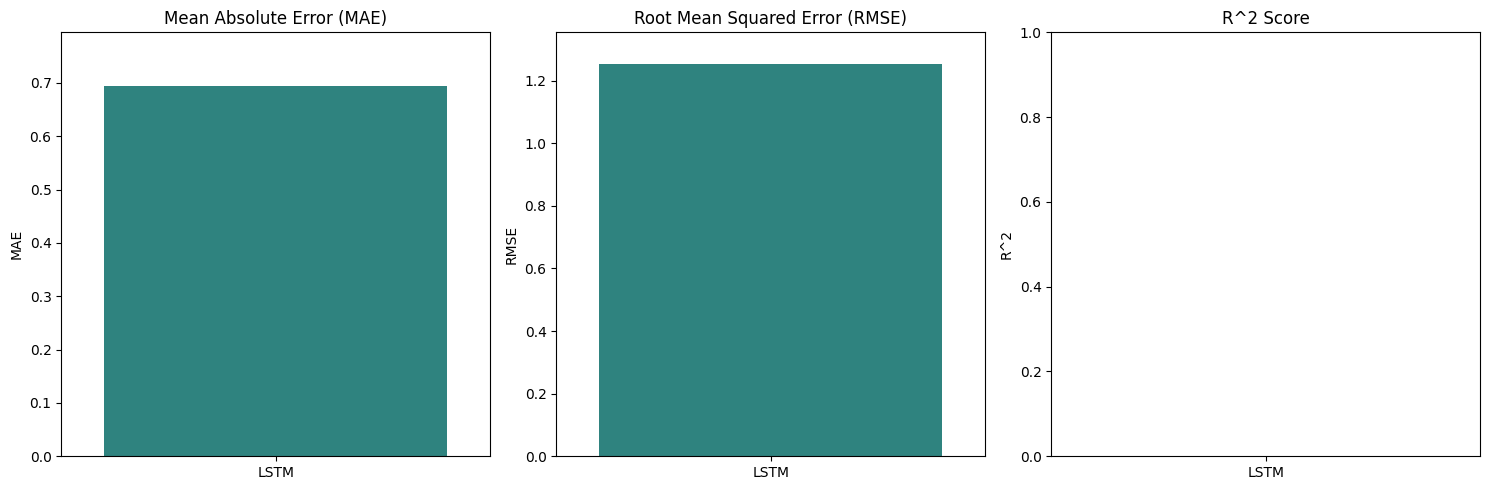

In [22]:
model_names = ["LSTM"]
avg_mae_values = [mae_lstm]
avg_rmse_values = [rmse_lstm]
avg_r2_values = [r2_lstm]

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=model_names, y=avg_mae_values, palette="viridis")
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.ylim(0, max(avg_mae_values) + 0.1)  # Adjusting y-limit for clarity

plt.subplot(1, 3, 2)
sns.barplot(x=model_names, y=avg_rmse_values, palette="viridis")
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.ylim(0, max(avg_rmse_values) + 0.1)  # Adjusting y-limit for clarity

plt.subplot(1, 3, 3)
sns.barplot(x=model_names, y=avg_r2_values, palette="viridis")
plt.title('R^2 Score')
plt.ylabel('R^2')
plt.ylim(0, 1)  # R^2 score is between 0 and 1

plt.tight_layout()
plt.show()